<a href="https://colab.research.google.com/github/yuchensun97/Machine-Learning-and-its-Application/blob/master/hw6_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
installing dependencies
"""
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!apt-get install x11-utils
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay


Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

In [0]:
import torch
import torchvision

import torch.utils.tensorboard as tb

from PIL import Image

from torch.utils import data 

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Homework 6 - Imitation and Reinforcement Learning

### Getting to know OpenAI Gym. (TODO)


We will be using the OpenAI Gym as our environment -- **we strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) .**


> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.


![](https://user-images.githubusercontent.com/8510097/31701297-3ebf291c-b384-11e7-8289-24f1d392fb48.PNG)


>The goal position is 0.5, the location of the flag on top of the hill.

>Reward: -1 for each time step, until the goal position of 0.5 is reached.

>Initialization: Random position from -0.6 to -0.4 with no velocity.

>Episode ends when you reach 0.5 position, or if 200 timesteps are reached. (So failure to reach the flag will result in a reward of -200).


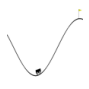

In [5]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)



def dummy_policy(env, num_episodes):

  '''
  TODO: Fill in this function 

  Functionality: This should be executing a random policy sampled from the action space of the environment for num_episodes long
                  and should be returning the mean reward over those episodes and the frames of the rendering recorded on the last episode 
  
  Input: env, the MountainCar environment object 
         num_episodes, int, the total number of episodes you want to run this for 

  Returns: mean_reward, float, which is the mean_reward over num_episodes 
           frames, a list, which should contain elements of image dimensions (i.e RGB, with size that you specify), should have a length of the last episode that you record.

  '''
  reward_ls = []    # list to record total reward per episode
  frames = deque(maxlen=200)    # buffer to store frames

  for i_episode in range(num_episodes):
    observation = env.reset()
    reward_episode = 0    # record total reward per episode

    for t in range(200):
      # env.render()    # generate a new environment
      action = env.action_space.sample()    # generate a random action
      observation,reward,done,info = env.step(action)    # return 4 value each time step, observation: position, velocity
      reward_episode+=reward
      
      # store obsearvations of the last episode
      if i_episode == num_episodes-1:
        frames.append(env.render())
      
      # episode ends when reach goal
      if done:
        break

    reward_ls.append(reward_episode)

  mean_reward = np.mean(reward_ls)    # calculate the mean reward over num_episode
  frames = np.stack(frames,axis=0)    # output frames 

  return mean_reward, frames

resize_observation_shape = 100
env = gym.make('MountainCar-v0')
env = ResizeObservation(env, resize_observation_shape)

rew, frames = dummy_policy(env, 10)

#### Video plotting code ######################
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## Expert Reinforcement Learning Code - Q-Learning


You are given the code for training a traditional Q-learning based agent. Please go through this code.

### Supporting functions

In [0]:
def discretize(state, discretization, env):

    env_minimum = env.observation_space.low
    state_adj = (state - env_minimum)*discretization
    discretized_state = np.round(state_adj, 0).astype(int)

    return discretized_state


def choose_action(epsilon, Q, state, env):
    """    
    Choose an action according to an epsilon greedy strategy.
    Args:
        epsilon (float): the probability of choosing a random action
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state (Box(2,)): the observation state, here it is [position, velocity]
        env: the RL environment 
        
    Returns:
        action (int): the chosen action
    """
    action = 0
    if np.random.random() < 1 - epsilon:
        action = np.argmax(Q[state[0], state[1]]) 
    else:
        action = np.random.randint(0, env.action_space.n)
  
    return action


def update_epsilon(epsilon, decay_rate):
    """
    Decay epsilon by the specified rate.
    
    Args:
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the decay rate (between 0 and 1) to scale epsilon by
        
    Returns:
        updated epsilon
    """
  
    epsilon *= decay_rate

    return epsilon


def update_Q(Q, state_disc, next_state_disc, action, discount, learning_rate, reward, terminal):
    """
    
    Update Q values following the Q-learning update rule. 
    
    Be sure to handle the terminal state case.
    
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state_disc (np.array): the discretized version of the current observation state [position, velocity]
        next_state_disc (np.array): the discretized version of the next observation state [position, velocity]
        action (int): the chosen action
        discount (float): the discount factor, may be referred to as gamma
        learning_rate (float): the learning rate, may be referred to as alpha
        reward (float): the current (immediate) reward
        terminal (bool): flag for whether the state is terminal
        
    Returns:
        Q, with the [state_disc[0], state_disc[1], action] entry updated.
    """    
    if terminal:        
        Q[state_disc[0], state_disc[1], action] = reward

    # Adjust Q value for current state
    else:
        delta = learning_rate*(reward + discount*np.max(Q[next_state_disc[0], next_state_disc[1]]) - Q[state_disc[0], state_disc[1],action])
        Q[state_disc[0], state_disc[1],action] += delta
  
    return Q

#### Wrapper for Rendering the Environment

In [0]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

### Main Q-learning Loop

In [0]:
def Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes=5000):
    """
    
    The main Q-learning function, utilizing the functions implemented above.
          
    """
    reward_list = []
    position_list = []
    success_list = []
    success = 0 # count of number of successes reached 
    frames = []
  
    for i in range(max_episodes):
        # Initialize parameters
        done = False # indicates whether the episode is done
        terminal = False # indicates whether the episode is done AND the car has reached the flag (>=0.5 position)
        tot_reward = 0 # sum of total reward over a single
        state = env.reset() # initial environment state
        state_disc = discretize(state,discretization,env)

        while done != True:                 
            # Determine next action 
            action = choose_action(epsilon, Q, state_disc, env)                                      
            # Get next_state, reward, and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            if i==1 or i==(max_episodes-1):
              frames.append(env.render())
            next_state, reward, done, _ = env.step(action) 
            # Discretize next state 
            next_state_disc = discretize(next_state,discretization,env)
            # Update terminal
            terminal = done and next_state[0]>=0.5
            # Update Q
            Q = update_Q(Q,state_disc,next_state_disc,action,discount,learning_rate, reward, terminal)  
            # Update tot_reward, state_disc, and success (if applicable)
            tot_reward += reward
            state_disc = next_state_disc

            if terminal: success +=1 
            
        epsilon = update_epsilon(epsilon, decay_rate) #Update level of epsilon using update_epsilon()

        # Track rewards
        reward_list.append(tot_reward)
        position_list.append(next_state[0])
        success_list.append(success/(i+1))

        if (i+1) % 100 == 0:
            print('Episode: ', i+1, 'Average Reward over 100 Episodes: ',np.mean(reward_list))
            reward_list = []
                
    env.close()
    
    return Q, position_list, success_list, frames

### Define Params and Launch Q-learning

In [9]:
# Initialize Mountain Car Environment
env = gym.make('MountainCar-v0')

env = ResizeObservation(env,100) #Resize observations

env.seed(42)
np.random.seed(42)
env.reset()

# Parameters    
learning_rate = 0.2 
discount = 0.9
epsilon = 0.8 
decay_rate = 0.95
max_episodes = 5000
discretization = np.array([10,100])


#InitQ
num_states = (env.observation_space.high - env.observation_space.low)*discretization
#Size of discretized state space 
num_states = np.round(num_states, 0).astype(int) + 1
print(num_states)
# Initialize Q table
Q = np.random.uniform(low = -1, 
                      high = 1, 
                      size = (num_states[0], num_states[1], env.action_space.n))

# Run Q Learning by calling your Qlearning() function
Q, position, successes, frames = Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes)

np.save('./expert_Q.npy',Q) #Save the expert

[19 15]
Episode:  100 Average Reward over 100 Episodes:  -200.0
Episode:  200 Average Reward over 100 Episodes:  -200.0
Episode:  300 Average Reward over 100 Episodes:  -199.31
Episode:  400 Average Reward over 100 Episodes:  -199.5
Episode:  500 Average Reward over 100 Episodes:  -187.22
Episode:  600 Average Reward over 100 Episodes:  -197.59
Episode:  700 Average Reward over 100 Episodes:  -193.0
Episode:  800 Average Reward over 100 Episodes:  -198.56
Episode:  900 Average Reward over 100 Episodes:  -178.68
Episode:  1000 Average Reward over 100 Episodes:  -179.05
Episode:  1100 Average Reward over 100 Episodes:  -177.91
Episode:  1200 Average Reward over 100 Episodes:  -157.72
Episode:  1300 Average Reward over 100 Episodes:  -185.27
Episode:  1400 Average Reward over 100 Episodes:  -176.04
Episode:  1500 Average Reward over 100 Episodes:  -191.86
Episode:  1600 Average Reward over 100 Episodes:  -184.11
Episode:  1700 Average Reward over 100 Episodes:  -170.33
Episode:  1800 Aver

### Visualization

#### Plotting

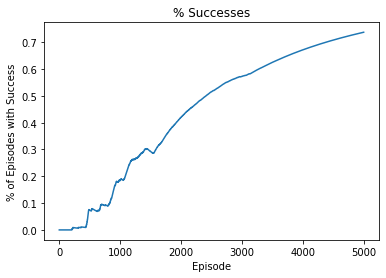

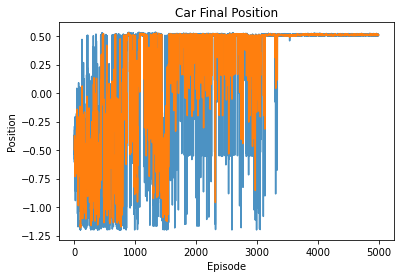

In [10]:
import pandas as pd 

plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(position)
ma = p.rolling(3).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

#### Agent's Video

In [0]:
#### Video plotting code #####################
deep_frames = []
for obs in frames:
  im = Image.fromarray(np.uint8(obs))
  im = im.resize((600,400))
  deep_frames.append(np.asarray(im))

plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
HTML(ani.to_jshtml())

### Generate Expert Trajectories (TODO):

Using the Q-learning agent above, please complete this block of code to generate expert trajectories

#### Get actions from expert for a specific observation

In [0]:

def get_expert_action(Q,discretization,env,state):
  '''
  TODO: Implement this function

  NOTE: YOU WILL BE USING THIS FUNCTION FOR THE IMITATION LEARNING SECTION AS WELL 

  Functionality: For a given state, returns the action that the expert would take 

  Input: Q value , numpy array
         the discretization 
         env , the environment
         state, (Box(2,)): the observation space state, here it is [position, velocity]

  Returns: action, has dimensions of the action space and type of action space
  '''
  state_disc = discretize(state,discretization,env)
  action = np.argmax(Q[state_disc[0],state_disc[1]])
  return action

#### Generate Expert Trajectory

In [0]:
import os
def generate_expert_trajectories(Q, discretization, env, num_episodes=150, data_path='./data'):

  '''
  TODO: Implement this function

  Functionality: Execute Expert Trajectories and Save them under the folder of data_path/

  Input: Q value , numpy array
         the discretization 
         env , the environment
         num_episodes, int, which is used to denote number of expert trajectories to store 
         
  Returns: total_samples, int, which denotes the total number of samples that were stored
  '''
  total_samples = 0
  for i in range(num_episodes):
    done = False    # indicate whether the episode is done
    state = env.reset()    # initial environment state
    episode_dict = {}
    episode_observations = []    # store observations per episode
    episode_actions = []    # store action per episode

    while done != True:
      action = get_expert_action(Q,discretization,env,state)    # get the expect action
      episode_observations.append(state)    # expand state
      episode_actions.append(action)    # expand action
      next_state,reward,done,_ = env.step(action)    # generate new state
      state = next_state    # update state
      total_samples+=1

    episode_dict['observations'] = episode_observations
    episode_dict['actions'] = episode_actions

    if not os.path.exists(data_path):
      os.makedirs(data_path)
    np.savez_compressed(data_path+'/episode_number'+'_'+str(i)+'.npz',**episode_dict) #where i can be the episode number that you save

  return total_samples 

#### Launch code for generating trajectories

In [13]:
num_episodes = 100
data_path = './data'

save_images = False
# Q = np.load('expert_Q.npy')
total_samples = generate_expert_trajectories(Q,discretization,env,num_episodes,data_path) ## Generate trajectories. Use Q, discretization and env by running the previous section

print('---------Total Samples Recorded were --------', total_samples)

---------Total Samples Recorded were -------- 14892


## Imitation Learning

Using the trajectories that you collected from the expert above, you will work on imitation learning agents in the code sections below

### Working with Data (TODO)




#### Loading Initial Expert Data

In [0]:
data = np.load('./data/episode_number_0.npz')
observations = data['observations']
action = data['actions']

In [0]:
from os import path
def load_initial_data(args):
  '''
  TODO: Fill this function

  Functionality: Reads data from directory and converts them into numpy arrays of observations and actions

  Input arguments: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
  
  Returns: training_observations: numpy array, of shape (B,dim_of_observation), where B is total number of samples that you select
           training_actions: numpy array, of shape (B,dim_of_action), where B is total number of samples that you select

  '''
  # initialization
  training_observations = np.array([[0,0]])
  training_actions = np.array([[0]])
  
  for i in range(args.initial_episodes_to_use):
    file_path = args.datapath+'/episode_number'+'_'+str(i)+'.npz'
    file = np.load(file_path)    # load data
    obs = file['observations']
    act = file['actions'].reshape(len(obs),-1)
    training_observations = np.r_[training_observations,obs]
    training_actions = np.r_[training_actions,act]

  training_observations = np.delete(training_observations,0,axis=0)
  training_actions = np.delete(training_actions,0,axis=0)

  return training_observations, training_actions

#### Convert numpy arrays to a Dataloader

In [0]:
def load_dataset(args, observations, actions, batch_size=64, data_transforms=None, num_workers=0):
  '''
  TODO: Fill this function fully 

  Functionality: Converts numpy arrays to dataloaders. 
  
  Inputs: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
          observations, numpy array, of shape (B,dim_of_observation), where B is number of samples 
          actions, numpy array, of shape (B,dim_of_action), where B is number of samples 
          batch_size, int, which you can play around with, but is set to 64 by default. 
          data_transforms, whatever transformations you want to make to your data.

  Returns: dataloader 
  '''
  from torch.utils.data import TensorDataset
  dataset = TensorDataset(torch.Tensor(observations),torch.Tensor(actions))
  dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

  return dataloader

#### Process Individual Observations

In [0]:
def process_individual_observation(args,observation):
  '''
  TODO: Fill this function fully 

  Functionality: Converts individual observations according to the pre-processing that you want  
  
  Inputs: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
          observations, shape (dim_of_observation)

  Returns: data, processed observation that can be fed into the model
  '''
  data = torch.from_numpy(observation.reshape(1,-1)).float()
  # data = args.transform(data)
  data = data.cuda()
  return data

### Defining Networks (TODO)

#### Define your network for working from States

In [0]:
class StatesNetwork(nn.Module):
  '''
  TODO: Implement this class
  '''
  def __init__(self, env):
    """
    Your code here
    """
    super(StatesNetwork,self).__init__()
    num_state = env.observation_space.shape[0]
    num_action = env.action_space.n
    self.fc1 = nn.Linear(num_state,100)
    self.fc2 = nn.Linear(100,num_action)

  def forward(self, x):    
    """
    Your code here
    @x: torch.Tensor((B,dim_of_observation))
    @return: torch.Tensor((B,dim_of_actions))
    """
    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    forward_pass = self.fc2(x)
    return forward_pass

### Training the model (TODO)

In [0]:
def train_model(args):

  '''
  TODO: Fill in the entire train function

  Functionality: Trains the model. How you train this is upto you. 

  Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 

  Returns: The trained model 

  '''
  # initialization

  running_loss = 0.0
  for i,batch in enumerate(args.dataloader):
    inputs,action = batch[0].cuda(),batch[1].cuda()
    action = action.reshape(-1)
    action = action.long()
    args.optimizer.zero_grad()

    # forward+backward+optimizer
    outputs = args.Net_to_use(inputs)
    loss = args.loss_fc(outputs,action)
    loss.backward()
    args.optimizer.step()

    running_loss+=loss.item()*inputs.size(0)
    loss_per_iteration = loss.item()
    
    args.train_loss.append(loss_per_iteration)
  
  average_loss = running_loss/args.len_dataset

  print('The training loss per epoch is : %f' % average_loss)

  model = args.Net_to_use

  return model

### DAgger (TODO)

#### Get the expert trajectory for imitating agent's observations

In [0]:
def execute_dagger(args):

  '''
  TODO: Implement this function

  Functionality: Collect expert labels for the observations seen by the imitation learning agent 
  
  Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
         
  Returns: imitation_observations, a numpy array that has dimensions of (episode_length,dim_of_observation)
           expert_actions, a numpy array that has dimensions of (episode_length,dim_of_action)
  '''
  Q = args.Q
  discretization = args.discretization
  env = args.env
  model = args.model
  model.eval()
  done = False
  expert_actions =[]
  imitation_observations = []
  imi_state = env.reset()
  epi_len = 0

  while done != True:
    action = get_expert_action(Q,discretization,env,imi_state)    # get the expert action
    expert_actions.append(action)    # expand expert action
    imitation_observations.append(imi_state)    # expand imitation state

    imi_action = process_individual_observation(args,imi_state)
    imi_action = model(imi_action)
    _,imi_action = torch.max(imi_action,axis=1)   # the imitation action
    imi_action = imi_action.item()

    next_state,_,done,_ = env.step(imi_action)    # generate new imitation state
    imi_state = next_state    # update imitation state
    epi_len+=1

  imitation_observations = np.array(imitation_observations).reshape(epi_len,-1)
  expert_actions = np.array(expert_actions).reshape(epi_len,-1)
  
          
  return imitation_observations, expert_actions

#### Aggregate new rollout to the full dataset

In [0]:
def aggregate_dataset(training_observations, training_actions, imitation_states, expert_actions):

  '''
  TODO: Implement this function

  Functionality: Adds new expert labeled rollout to the overall dataset

  Input: training_observations, a numpy array that has dimensions of (dataset_size,dim_of_observation)
         training_actions, a numpy array that has dimensions of (dataset_size,dim_of_action)
         imitation_observations, a numpy array that has dimensions of (episode_length,dim_of_observation)
         expert_actions, a numpy array that has dimensions of (episode_length,dim_of_action)

  Returns: training_observations, a numpy array that has dimensions of (updated_dataset_size,dim_of_observation)
           training_actions, a numpy array that has dimensions of (updated_dataset_size,dim_of_action)
  '''
  training_observations = np.r_[training_observations,imitation_states]
  training_actions = np.r_[training_actions,expert_actions]

  return training_observations, training_actions 

### Utility 



#### Code for prediction of the network and calculating the accuracy 

In [0]:
import numpy as np
from torchvision.transforms import functional as TF

def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

#### Wrapper for Rendering the environment 

Same code that was used in the Q-learning agent

In [0]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

### Test model performance

In [0]:
def test_model(args, record_frames=False):

    '''
  Functionality: Should take your model and run it for a complete episode (model should either not finish the game in 200 steps or finish the game). Record stats

  Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
         record_frames, Boolean. Denotes if you want to record frames to display them as video.

  Returns: final_position, The final position of the car when the episode ended
           success, Boolean, denotes if the episode was a success or not
           frames, a list of frames that have been rendered throughout the episode. Should have a length of the total episode length
           episode_reward, float, denotes the total rewards obtained while executing this episode
  '''

    frames = []
    env = args.env 
    model = args.model
    state = env.reset()

    model.eval()

    episode_reward = 0

    success = False
    done = False 

    while not done:

        observation = state
        data = process_individual_observation(args,observation)
        logit = model(data)
        action = torch.argmax(logit).item()

        if record_frames: #You can change the rate of recording frames as you like
            frames.append(env.render())

        next_state, reward, done, _ = env.step(action) 
        episode_reward += reward

        if done:    
            if next_state[0] >= 0.5:
                success = True
            final_position = next_state[0]
            return final_position,success, frames, episode_reward
        else:
            state = next_state

### Main Imitation Learning Method (TODO)



In [0]:
def imitate(args):
  '''
  TODO: Implement this function

  Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 

  Functionality: For a given set of args, performs imitation learning as desired. 

  Returns: final_positions, A list of final positions achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
           success_history, A list of success percentage achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
           reward_history, A list of episode rewards achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
           frames, A list of video frames of the model executing its policy every time it is tested, can choose to not record. Should have a length of the number of times you chose to record frames
           args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access
  '''
  final_positions = []
  success_history= []
  frames = deque()
  reward_history = []
  training_observations, training_actions = load_initial_data(args)
  args.dataloader = load_dataset(args,training_observations,training_actions, 
                            args.batch_size,args.transform)
  args.len_dataset = len(training_observations)
  args.Net_to_use = args.Net
  dagger_bool = args.do_dagger
  init_episode = args.initial_episodes_to_use
  max_dagger_iteration = args.max_dagger_iterations
  if dagger_bool is True:
    num_epochs = args.num_epochs + max_dagger_iteration
  else:
    num_epochs = args.num_epochs


  # define imitation loop
  for e in range(num_epochs):

    # do dagger
    if dagger_bool is True and e>= args.num_epochs:
      imitation_observations, expert_actions = execute_dagger(args)
      training_observations, training_actions = aggregate_dataset(training_observations, training_actions, 
                                                                  imitation_observations, expert_actions)
      args.dataloader = load_dataset(args,training_observations,training_actions,
                                     args.batch_size,args.transform)
      args.len_dataset = len(training_observations)

    # train the model
    args.model = train_model(args)

    # test on 5 episode every epoch
    final_pos = 0
    successes = 0
    rewards = 0

    for ep in range(5):
      pos, success, frames_epi, episode_rewards = test_model(args, record_frames=False)   #test imitation policy
      final_pos += pos 
      rewards += episode_rewards
      if success:
        successes += 1
      print('Running Episode: ',ep,' Success: ', success)
      average_final_positions = final_pos/(ep+1)
      average_success_rate = 100*(successes/(ep+1))
      average_episode_rewards = rewards/(ep+1) 
      frames.append(frames_epi)
    
    final_positions.append(average_final_positions)
    success_history.append(average_success_rate)
    reward_history.append(average_episode_rewards)


  return final_positions, success_history, frames, reward_history, args

### Launch Imitation Learning (TODO)
Define Args and Launch 'imitate'



In [123]:
'''
TODO: Expand the attributes of Args as you please. 

But please maintain the ones given below, i.e: You should be using the ones given below. Fill them out.

Some of these are already filled out for you. 
'''


##TODO: Fill in the given attributes (you should use these in your code), and add to them as you please.
class Args(object):
  pass


args = Args();
args.datapath = './data'
env = gym.make('MountainCar-v0')
env = ResizeObservation(env, resize_observation_shape)
args.env = env
args.num_episode = 20
args.batch_size = 64
args.transform = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor()])
args.do_dagger = True
args.max_dagger_iterations = 18
if not args.do_dagger:
  assert args.max_dagger_iterations==1
args.record_frames = False
args.initial_episodes_to_use = 2
args.num_epochs = 2
args.Q = np.load('./expert_Q.npy',allow_pickle=True)
args.discretization = np.array([10,100])
args.lr = 0.05
args.Net = StatesNetwork(args.env).cuda()
args.optimizer = optim.Adam(args.Net.parameters(),args.lr)
args.loss_fc = nn.CrossEntropyLoss()
args.train_loss=[]

positions, successes, frames, reward_history, args = imitate(args)

The training loss per epoch is : 1.075769
Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
The training loss per epoch is : 0.906103
Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
The training loss per epoch is : 0.883859
Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
The training loss per epoch is : 0.769268
Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
The training loss per epoch is : 0.734423
Running Episode:  0  Success:  False
Running Episo

In [125]:
print(reward_history)

[-200.0, -200.0, -200.0, -200.0, -198.0, -158.2, -135.2, -137.0, -129.4, -137.2, -144.0, -138.6, -138.2, -137.4, -144.6, -135.4, -139.2, -172.2, -147.2, -146.6]


### Average Performance Metrics

Use this function to see how well your agent is doing. 

In [124]:
def get_average_performance(args, run_for=1000):

  final_positions = 0
  successes = 0
  rewards = 0

  for ep in range(run_for):
    pos, success, _, episode_rewards = test_model(args, record_frames=False)   #test imitation policy
    final_positions += pos 
    rewards += episode_rewards
    if success:
      successes += 1
    print('Running Episode: ',ep,' Success: ', success)
    average_final_positions = final_positions/(ep+1)
    average_success_rate = 100*(successes/(ep+1))
    average_episode_rewards = rewards/(ep+1)

  return average_final_positions, average_success_rate, average_episode_rewards 


final_pos, succ_rate, ep_rwds = get_average_performance(args)

print('Average Final Position achieved by the Agent: ',final_pos)
print('Average Success Rate achieved by the Agent: ',succ_rate)
print('Average Episode Reward achieved by the Agent: ',ep_rwds)

Running Episode:  0  Success:  True
Running Episode:  1  Success:  True
Running Episode:  2  Success:  True
Running Episode:  3  Success:  True
Running Episode:  4  Success:  True
Running Episode:  5  Success:  True
Running Episode:  6  Success:  True
Running Episode:  7  Success:  True
Running Episode:  8  Success:  True
Running Episode:  9  Success:  True
Running Episode:  10  Success:  True
Running Episode:  11  Success:  True
Running Episode:  12  Success:  True
Running Episode:  13  Success:  True
Running Episode:  14  Success:  True
Running Episode:  15  Success:  True
Running Episode:  16  Success:  True
Running Episode:  17  Success:  True
Running Episode:  18  Success:  True
Running Episode:  19  Success:  True
Running Episode:  20  Success:  True
Running Episode:  21  Success:  True
Running Episode:  22  Success:  True
Running Episode:  23  Success:  True
Running Episode:  24  Success:  True
Running Episode:  25  Success:  True
Running Episode:  26  Success:  True
Running Epi

### Visualization

#### Plotting code

Use the code below to make plots to see how well your agent did as it trained. 

In [0]:
import pandas as pd 

plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(positions)
ma = p.rolling(3).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Episode Rewards Achieved')
plt.title('Episode Rewards')
plt.show()
plt.close()


#### Make a video!

Using the frames that you recorded in ``` frames ```, Run the code below to display a video that you can use to see how well your agent is doing



In [0]:
#### Video plotting code #####################
deep_frames = []
for f in frames:
  deep_frames += f
plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
HTML(ani.to_jshtml())

